This notebook details experiments around the open-source benchmark dockstring

In [1]:
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt
from pathlib import Path 


RANDOM_STATE=0
np.random.seed(RANDOM_STATE)

In [2]:
def compute_enrichment_factor(scores, labels, n_percent):
    # this variant implements the equation from Xiaohua's paper
    
    sample_n = int(np.ceil(n_percent * labels.shape[0]))
    
    sorted_scores = sorted(zip(scores, labels), key=lambda x: x[0], reverse=True)

    top_n_sorted_scores = sorted_scores[:sample_n]

    # counting number of true positives in top x% of sorted compounds
    actives_sampled = sum([y for x, y in top_n_sorted_scores])
    # labels are binary, sum to count number of actives
    actives_database = sum(labels)

    norm_factor = (sample_n/len(labels))

    return (actives_sampled / actives_database) * (labels.shape[0]/sample_n)


In [3]:
df = pd.read_csv("dockstring-dataset.tsv", delim_whitespace=True).sample(frac=1.0)

In [4]:
df

,inchikey,smiles,PPARD,ABL1,ADAM17,ADRB1,ADRB2,AKT2,MAOB,CASP3,...,EGFR,F10,GBA,MAPK1,MAPK14,PLK1,SRC,THRB,F2,KDR
12468,ZHDALENJLZAVPB-ZMOGYAJENA-N,O=C1N(/N=C/C=2C=CC(=CC2)C(OC)=O)C(N(C1)C(C)C)C...,-8.1,-8.4,-8.5,-9.2,-9.3,-7.8,-5.3,-7.6,...,-7.9,-8.9,-8.9,-8.0,-7.6,-7.8,-8.0,-6.3,-7.7,-7.6
175276,QUIBTSSQCJXKHN-LILDFLRNNA-N,ClC=1C=C(COC(=O)C2=CC=C(NC(=O)C)C=C2)C=CC1Cl,-8.8,-9.8,-8.8,-9.1,-9.0,-8.3,-9.2,-7.1,...,-9.0,-7.9,-8.5,-8.7,-8.3,-8.7,-8.1,-9.6,-7.8,-9.6
218532,TZCIQCNJFXCYEF-UYBDAZJANA-N,C1CCC2=C(C(C#N)=C(S2)NC(=O)CC3=CC=CC=C3Br)C1,-9.0,-9.0,-8.4,-8.6,-8.8,-8.3,-9.9,-7.2,...,-8.9,-7.2,-8.8,-8.2,-7.5,-8.8,-7.9,-9.6,-7.4,-8.7
32764,WRSUPAJSUHYUKP-UHFFFAOYNA-N,C=1C=C(SCCCN2CCN(CC2)C=3N=CC=CN3)C=CC1F,-8.5,-8.8,-8.3,-8.6,-8.8,-7.4,-8.3,-7.0,...,-8.3,-8.3,-8.3,-7.6,-7.1,-8.1,-7.1,-9.5,-8.0,-8.5
224489,JOEJPTCXPNVNFV-NJIMMUGSNA-N,S(=O)(=O)(N1CCOCC1)C=2C=C(C=CC2)C(=O)N/N=C/C=3...,-8.8,-9.6,-8.2,-9.8,-10.1,-9.0,-7.0,-7.7,...,-9.7,-8.0,-9.1,-8.4,-7.6,-9.5,-7.9,-9.9,-8.4,-10.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176963,RMXFPOWCDQAFLR-JAFMVTPMNA-N,S(=O)(=O)(N)C1=CC(NC(=O)COC2=CC=C(C(=O)C=3C=CC...,-10.3,-10.0,-9.7,-10.3,-10.3,-9.5,-7.2,-8.4,...,-9.7,-8.7,-10.7,-9.7,-8.8,-10.3,-8.6,-9.8,-8.2,-10.0
117952,SDIBACPBJGDOIR-UHFFFAOYNA-N,S(C(=S)N(C1CCCCC1)C)CC(=O)C=2C=3C(NC2C)=CC=CC3,-8.6,-9.8,-8.7,-9.0,-8.8,-6.9,-8.5,-7.0,...,-8.3,-8.4,-8.7,-8.5,-7.7,-8.5,-7.4,-9.0,-7.8,-8.5
173685,FJSNPZHVXJHWHW-UYBDAZJANA-N,S1CCN(C2=C1C=CC(=C2)C(=O)NC(C3=CC=CC=C3)C)CC,-9.2,-9.1,-9.0,-9.0,-8.7,-8.2,-9.0,-6.8,...,-8.9,-8.1,-9.7,-8.3,-7.4,-8.8,-7.9,-10.0,-7.4,-8.8
43567,RZWSTRMPTUDUIU-GPQMBLKYNA-N,C=1(C=C2C(=CC1)NC=3C(N(CCC23)CC)C(=O)O)OC,-6.9,-8.3,-8.2,-8.2,-8.0,-7.4,-6.1,-6.5,...,-7.6,-6.8,-8.0,-8.8,-7.0,-8.4,-7.5,-7.4,-7.1,-7.3


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

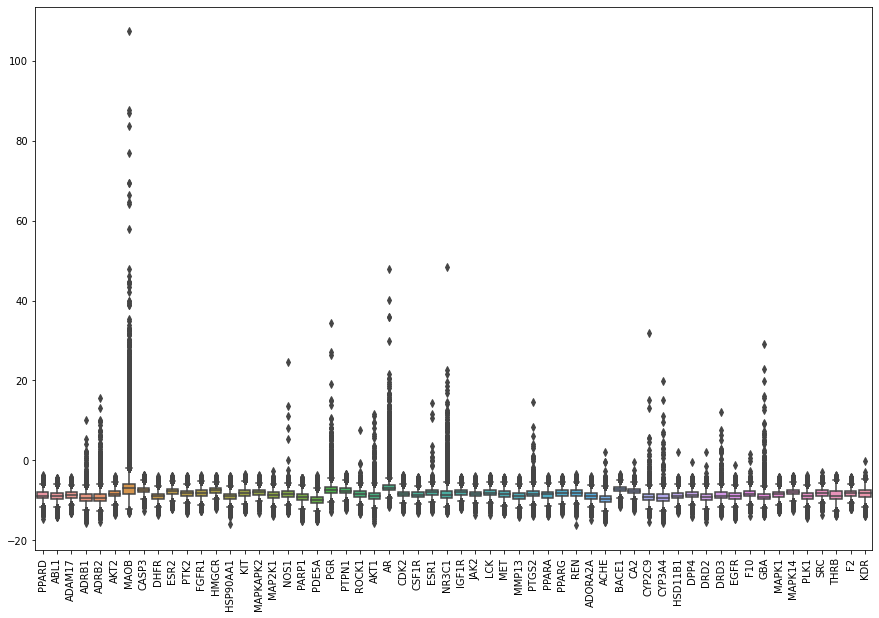

In [6]:
f, ax = plt.subplots(1,1, figsize=(15, 10))
sns.boxplot(data=df[[x for x in df.columns if x not in ["inchikey", "smiles"]]], ax=ax)
ax.tick_params(axis='x', labelrotation=90)

In [7]:
# f, ax = plt.subplots(1,1, figsize=(15, 10))
# sns.violinplot(data=df[[x for x in df.columns if x not in ["inchikey", "smiles"]]], ax=ax)
# ax.tick_params(axis='x', labelrotation=90)

In [8]:
import deepchem as dc
from rdkit import Chem

In [9]:
feat_calc = dc.feat.CircularFingerprint(size=1024, radius=2)

In [10]:
# have an issue with the import
# from atomsci.ddm.pipeline.diversity_plots import plot_tani_dist_distr

In [11]:
from atomsci.ddm.pipeline import  chem_diversity as cd
import logging
logging.basicConfig(format='%(asctime)-15s %(message)s')


def plot_tani_dist_distr(df, smiles_col, df_name, radius=2, subset_col='subset', subsets=False, 
                         ref_subset='train', plot_width=6, ndist_max=None, **metric_kwargs):
    """
    Generate a density plot showing the distribution of nearest neighbor distances between 
    ecfp feature vectors, using the Tanimoto metric. Optionally split by subset.
    Args:
        df (DataFrame): A data frame containing, at minimum, a column of SMILES strings.
        smiles_col (str): Name of the column containing SMILES strings.
        df_name (str): Name for the dataset, to be used in the plot title.
        radius (int): Radius parameter used to calculate ECFP fingerprints. The default is 2, meaning that ECFP4
        fingerprints are calculated.
        subset_col (str): Name of the column containing subset names.
        subsets (bool): If True, distances are only calculated for compounds not in the reference subset, and the
        distances computed are to the nearest neighbors in the reference subset.
        ref_subset (str): Reference subset for nearest-neighbor distances, if `subsets` is True.
        plot_width (float): Plot width in inches.
        ndist_max (int): Not used, included only for backward compatibility.
        metric_kwargs: Additional arguments to pass to metric. Not used, included only for backward compatibility.
    Returns:
        dist (DataFrame): Table of individual nearest-neighbor Tanimoto distance values. If subsets is True,
        the table will include a column indicating the subset each compound belongs to.
    """
    log = logging.getLogger('ATOM')
    num_cmpds = len(df)
    # TODO: Make max compounds a parameter, rather than hardcoding to 50000. Better yet, calculate a sample
    # of distances of size ndist_max for each non-reference subset, and plot KDEs based on the samples.
    if num_cmpds > 50000:
        log.warning("Dataset has %d compounds, too big to calculate distance matrix" % num_cmpds)
        return

    if subsets and subset_col not in df.columns:
        log.warning(f"{subset_col} column not found. Calculating total tanimoto distances instead.")
        subsets=False
    feat_type = 'ecfp'
    dist_metric = 'tanimoto'
    if not subsets:
        smiles_arr1 = df[smiles_col].values
        dists=cd.calc_dist_smiles(feat_type, dist_metric, smiles_arr1, calc_type='nearest', num_nearest=1)
        subs=['all']*len(dists)
        dists=pd.DataFrame(zip(dists,subs), columns=['dist','subset'])
    elif subsets:
        dists=pd.DataFrame([], columns=['dist','subset'])
        for subs in df[subset_col].unique():
            if subs==ref_subset: continue
            smiles_arr1 = df.loc[df[subset_col]==ref_subset, smiles_col].values
            smiles_arr2 = df.loc[df[subset_col]==subs, smiles_col].values
            diststmp = cd.calc_dist_smiles(feat_type, dist_metric, smiles_arr2, smiles_arr2=smiles_arr1, calc_type='nearest', num_nearest=1)
            substmp=[subs]*len(diststmp)
            diststmp = pd.DataFrame(zip(diststmp,substmp), columns=['dist','subset'])
            dists=pd.concat([dists,diststmp])
    dists=dists.reset_index(drop=True)
    fig, ax = plt.subplots(figsize=(plot_width, plot_width))
    sns.kdeplot(data=dists[dists.subset!=ref_subset], x='dist', hue='subset', legend=True, common_norm=False, common_grid=True, fill=False, ax=ax)
    ax.set_xlabel('%s distance' % dist_metric)
    ax.set_ylabel('Density')
    if not subsets:
        ax.set_title("%s dataset\nDistribution of %s nearest neighbor distances between %s feature vectors" % (
                      df_name, dist_metric, feat_type))
    else: 
        ax.set_title(f"{df_name} dataset: Distribution of {dist_metric} distances\nbetween {feat_type} feature vectors from non-{ref_subset} subsets\nto their nearest neighbors in the {ref_subset} subset")

    return dists

In [12]:
# g = plot_tani_dist_distr(df=df, smiles_col="smiles", df_name="DOCKSTRING cross-docked")

In [13]:
# g

In [ ]:
from tqdm import tqdm 
def compute_fp(smiles):
    return feat_calc.featurize(smiles)

import multiprocessing as mp

with mp.Pool(64) as pool:
    result = list(tqdm(pool.imap(compute_fp, df["smiles"]), total=len(df)))
import numpy as np
fp_data = np.vstack(result)
fp_data = fp_data.astype(np.int8)

100%|██████████| 260155/260155 [00:28<00:00, 9193.12it/s] 


now we compute the cutoff values for the docking scores using the threshold for which 90% of the data would be labeled inactive, i.e. we find the top 10% cutoff threshold and use that to label active/inactive

In [ ]:
import deepchem as dc

splitter = dc.splits.RandomSplitter()


def parallel_splitter(tup):
    root_dir = Path("/g/g13/jones289/workspace/hd-cuda-master/datasets/dockstring")

    # col = target_name, item=dock_scores_col
    col, item = tup

    
    dataset_smiles = df['smiles'].values
    
#     print(col)
#     col, item = tup
    
    train_p = root_dir / Path(f"random/{col}/train.npy")
    test_p = root_dir / Path(f"random/{col}/test.npy")
    
    train_smiles_p = root_dir / Path(f"random/{col}/train_smiles.npy")
    test_smiles_p = root_dir / Path(f"random/{col}/test_smiles.npy")

    tqdm.write(str(train_p))
#     print(test_p)
        
#     cutoff = item.quantile(.1)
#     labels_mask = item < cutoff
    
#     labels = labels_mask.astype(np.int8).values.reshape(-1,1)
    
    
#     pos_dataset = dc.data.DiskDataset.from_numpy(X=fp_data[labels_mask], y=labels[labels_mask], ids=dataset_smiles[labels_mask])
#     neg_dataset = dc.data.DiskDataset.from_numpy(X=fp_data[~labels_mask], y=labels[~labels_mask], ids=dataset_smiles[~labels_mask])
    
    '''
    pos_train, pos_test = splitter.train_test_split(pos_dataset)
    neg_train, neg_test = splitter.train_test_split(neg_dataset)

    

    train_data = np.vstack((pos_train.X, neg_train.X))
    train_labels = np.vstack((pos_train.y, neg_train.y))
    train_arr = np.hstack((train_data, train_labels))
    train_smiles = np.vstack((pos_train.ids, neg_train.ids))
        
    
    test_data = np.vstack((pos_test.X, neg_test.X))
    test_labels = np.vstack((pos_test.y, neg_test.y))
    test_arr = np.hstack((test_data, test_labels))
    test_smiles = np.vstack((pos_test.ids, neg_test.ids))

    
    if not train_p.exists():
        train_p.parent.mkdir(parents=True, exist_ok=True)
    
    if not test_p.exists():
        test_p.parent.mkdir(parents=True, exist_ok=True)
    
    np.save(train_p, train_arr)
    np.save(test_p, test_arr)
        
    np.save(train_smiles_p, train_smiles)
    np.save(test_smiles_p, test_smiles)
    '''



def make_dockstring_random_split():

    splitter = dc.splits.RandomSplitter()


    dataset_smiles = df['smiles'].values


    root_dir = Path("/g/g13/jones289/workspace/hd-cuda-master/datasets/dockstring")
    
    
    
    job_list = [(col, item) for col, item in df.items() if col not in ["inchikey", "smiles"]]
    
    import multiprocessing as mp
    
    with mp.Pool(int(mp.cpu_count()/4)) as pool:
        
        result = list(tqdm(pool.imap(parallel_splitter, job_list), total=len(job_list)))
    

    # the for loop is a little funky but this is just iterating over target names in the dockstring .csv
#     for col, item in tqdm([(col, item) for col, item in df.items() if col not in ["inchikey", "smiles"]]):
  

#         train_p = root_dir / Path(f"random/{col}/train.npy")
#         test_p = root_dir / Path(f"random/{col}/test.npy")

#         print(train_p)
#         print(test_p)
        
#         cutoff = item.quantile(.1)
#         labels_mask = item < cutoff
    
#         labels = labels_mask.astype(np.int8).values.reshape(-1,1)
#         np.column_stack((fp_data,labels))
    
    
#         pos_dataset = dc.data.DiskDataset.from_numpy(X=fp_data[labels_mask], y=labels[labels_mask], ids=dataset_smiles[labels_mask])
#         neg_dataset = dc.data.DiskDataset.from_numpy(X=fp_data[~labels_mask], y=labels[~labels_mask], ids=dataset_smiles[~labels_mask])
    
#         pos_train, pos_test = splitter.train_test_split(pos_dataset)
#         neg_train, neg_test = splitter.train_test_split(neg_dataset)

    

#         train_data = np.vstack((pos_train.X, neg_train.X))
#         train_labels = np.vstack((pos_train.y, neg_train.y))
#         train_arr = np.hstack((train_data, train_labels))
#         train_smiles = np.vstack((pos_train.ids, neg_train.ids))
        
    
#         test_data = np.vstack((pos_test.X, neg_test.X))
#         test_labels = np.vstack((pos_test.y, neg_test.y))
#         test_arr = np.hstack((test_data, test_labels))
#         test_smiles = np.vstack((pos_test.ids, neg_test.ids))

    
#         if not train_p.exists():
#             train_p.parent.mkdir(parents=True, exist_ok=True)
    
#         if not test_p.exists():
#             test_p.parent.mkdir(parents=True, exist_ok=True)
    
#         np.save(train_p, train_arr)
#         np.save(test_p, test_arr)
        
#         np.save(train_smiles_p, train_smiles)
#         np.save(test_smiles_p, test_smiles)
    
make_dockstring_random_split()

# scaffold split

import deepchem as dc



def make_dockstring_scaffold_split():

    splitter = dc.splits.ScaffoldSplitter()


    dataset_smiles = df['smiles'].values

    from pathlib import Path 

    root_dir = Path("/g/g13/jones289/workspace/hd-cuda-master/datasets/dockstring")

    # the for loop is a little funky but this is just iterating over target names in the dockstring .csv
    for col, item in tqdm([(col, item) for col, item in df.items() if col not in ["inchikey", "smiles"]]):
  

        train_p = root_dir / Path(f"scaffold/{col}/train.npy")
        test_p = root_dir / Path(f"scaffold/{col}/test.npy")

        print(train_p)
        print(test_p)
        
        cutoff = item.quantile(.1)
        labels_mask = item < cutoff
    
        labels = labels_mask.astype(np.int8).values.reshape(-1,1)
        np.column_stack((fp_data,labels))
    
    
        pos_dataset = dc.data.DiskDataset.from_numpy(X=fp_data[labels_mask], y=labels[labels_mask], ids=dataset_smiles[labels_mask])
        neg_dataset = dc.data.DiskDataset.from_numpy(X=fp_data[~labels_mask], y=labels[~labels_mask], ids=dataset_smiles[~labels_mask])

    
        
    
        pos_train, pos_test = splitter.train_test_split(pos_dataset)
        neg_train, neg_test = splitter.train_test_split(neg_dataset)

    

        train_data = np.vstack((pos_train.X, neg_train.X))
        train_labels = np.vstack((pos_train.y, neg_train.y))
        train_arr = np.hstack((train_data, train_labels))
    
        test_data = np.vstack((pos_test.X, neg_test.X))
        test_labels = np.vstack((pos_test.y, neg_test.y))
        test_arr = np.hstack((test_data, test_labels))
    
        if not train_p.exists():
            train_p.parent.mkdir(parents=True, exist_ok=True)
    
        if not test_p.exists():
            test_p.parent.mkdir(parents=True, exist_ok=True)
    
        np.save(train_p, train_arr)
        np.save(test_p, test_arr)
    
make_dockstring_scaffold_split()

# Results

In [ ]:
from pathlib import Path
data_p = Path("/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/results")
data_p

In [ ]:
list(data_p.glob("*dockstring*"))

In [ ]:
def load_pkl(pkl_path, model, return_sizes=False):
    
    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        
        
        if 0 in data.keys():
            data = data[0]

        
        if "encode_time" not in data.keys():
            return
    
    if isinstance(data["y_true"], np.ndarray):
        y_true = data["y_true"]
    else:
        y_true = np.concatenate(data["y_true"]) 
    y_pred = np.array(data["y_pred"])

    
    eta = np.array(data["eta"])

    if np.unique(y_true).shape[0] < 2 :
        metric = 0
    else:
        metric = recall_score(y_pred=y_pred, y_true=y_true)
        if model in ["rf", "mlp"]:
            eta= eta[:, 1]

    print(pkl_path)
    if return_sizes:
        return y_true, y_pred, eta, metric, data["encode_time"], data["train_time"], data["test_time"], data["train_size"], data["test_size"]
    else:
        return y_true, y_pred, eta, metric, data["encode_time"], data["train_time"], data["test_time"]


In [ ]:
color_dict = {
#     "smiles-pe": "steelblue",
#     "ecfp": "lightcoral",
#     "rp": "seagreen",
#     "rf": "plum",
#     "openhd": "green",
    "mlp": "slateblue"
}

marker_dict = {
#     "smiles-pe": "+",
#     "ecfp": "+",
#     "rp": "+",
#     "rf": "^",
#     "openhd": "*",
    "mlp": "+"
}


def aggregate_dockstring_results(dataset, split):
    
    model_metric_dict = {}
    
    
    enrich_1_f, enrich_1_ax = plt.subplots(1,1, figsize=(16,6))
    enrich_10_f, enrich_10_ax = plt.subplots(1,1, figsize=(16,6))

    
    enrich_1_f.suptitle("Enrichment at 1\% of database")
    enrich_10_f.suptitle("Enrichment at 10\% of database")
    
    f, ax = plt.subplots(1,3, figsize=(16,6))
    ax = ax.flatten()

    for model, color in color_dict.items():
        
        marker = marker_dict[model]
#         color, marker = model_tup
        
        model_metric_dict[model] = []
        
        metric_list = []
        encode_time_list = []
        train_time_list = []
        test_time_list = []
        eta_list = []
        
#         import pdb
#         pdb.set_trace()
        data_path_list = list(data_p.glob(f"{dataset}.{split}.*.{model}.pkl"))
#         !list(data_p.glob(f"{dataset}*"))
        train_size_list = []
        test_size_list = []
        target_size_list = []
        
        
        enrich_1_list = []
        enrich_10_list = []
        
        for path in data_path_list:
#             import ipdb 
#             ipdb.set_trace()
            target = path.stem.split(".")[2]
            split = path.stem.split(".")[1]
            
            y_true, y_pred, eta, m, encode_time, train_time, test_time, train_size, test_size = load_pkl(path, model=model, return_sizes=True)
            
            if m is None:
                pass
            else:
                metric_list.append(m)
                encode_time_list.append(encode_time)
                train_time_list.append(train_time/10) # because i retrained 10 times
                test_time_list.append(test_time)
                eta_list.append(eta)
                train_size_list.append(train_size)
                test_size_list.append(test_size)
                
                enrich_1 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.01)
                enrich_1_list.append(enrich_1)
                
                enrich_10 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.1)
                enrich_10_list.append(enrich_10)

                target_size_list.append(train_size+test_size)
                
                model_metric_dict[model].append((m, enrich_1, enrich_10))
                
        sorted_metric_list = [x for _, x in sorted(zip(target_size_list, metric_list), key=lambda pair: pair[0])]
        sorted_encode_time_list = [x for _, x in sorted(zip(target_size_list, encode_time_list), key=lambda pair: pair[0])]
        sorted_train_time_list = [x for _, x in sorted(zip(target_size_list, train_time_list), key=lambda pair: pair[0])]
        sorted_test_time_list = [x for _, x in sorted(zip(target_size_list, test_time_list), key=lambda pair: pair[0])]
        sorted_enrich_1_list = [x for _, x in sorted(zip(target_size_list, enrich_1_list), key=lambda pair: pair[0])]
        sorted_enrich_10_list = [x for _, x in sorted(zip(target_size_list, enrich_10_list), key=lambda pair: pair[0])]
        sorted_train_size_list = sorted(train_size_list)
                
        if model not in ["rf", "mlp"]:
            sns.scatterplot(x=[x for x in range(len(target_size_list))], y=sorted_encode_time_list, ax=ax[1], color=color, marker=marker, label=model)
        sns.scatterplot(x=[x for x in range(len(target_size_list))], y=sorted_train_time_list, ax=ax[2], color=color, marker=marker, label=model)


    ax[0].set_ylabel("roc-auc-score")
    ax[0].set_xlabel("DUD-E target")

    plt.legend()
    return f, ax, enrich_1_f, enrich_1_ax, enrich_10_f, enrich_10_ax, model_metric_dict




In [ ]:
dockstring_f, dockstring_ax, dockstring_enrich_1_f, dockstring_enrich_1_ax, dockstring_enrich_10_f, dockstring_enrich_10_ax, model_metric_dict = aggregate_dockstring_results(dataset="dockstring", split="random")
# plt.savefig('dude-results-all.png', dpi=600)


# for model, metric_dist in model_metric_dict.items():

In [ ]:
model_metric_dict

In [ ]:
model_metric_dict[list(model_metric_dict.keys())[0]]

In [ ]:
model_metric_df = pd.DataFrame(model_metric_dict)
model_metric_df_list = [pd.DataFrame({"metric": [tup[0] for tup in model_metric_df[col].values], 
                                      "enrich-1": [tup[1] for tup in model_metric_df[col].values],
                                      "enrich-10": [tup[2] for tup in model_metric_df[col].values],
                                      "model": [col]*len(model_metric_df)}) for col in model_metric_df.columns]

model_metric_df = pd.concat(model_metric_df_list)
model_metric_df

In [ ]:
sns.boxplot(data=model_metric_df, x="model", y="metric", ax=dockstring_ax[0], palette=color_dict)
dockstring_f